# Autotalker Batch Integration Mouse Organogenesis Imputed

- **Creator**: Sebastian Birk (<sebastian.birk@helmholtz-munich.de>).
- **Affiliation:** Helmholtz Munich, Institute of Computational Biology (ICB), Talavera-López Lab
- **Date of Creation:** 30.01.2023
- **Date of Last Modification:** 31.01.2023

## 1. Setup

### 1.1 Import Libraries

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../../autotalker")

In [3]:
import argparse
import os
import pickle
import random
import warnings
from copy import deepcopy
from datetime import datetime

import anndata as ad
import bbknn
import matplotlib
import matplotlib.pyplot as plt
import mlflow
import numpy as np
import pandas as pd
import scanpy as sc
import scib
import scipy.sparse as sp
import seaborn as sns
import squidpy as sq
import torch
from matplotlib.pyplot import rc_context
from sklearn.decomposition import KernelPCA

from autotalker.benchmarking import compute_rclisi, compute_cad
from autotalker.models import Autotalker
from autotalker.utils import (add_gps_from_gp_dict_to_adata,
                              extract_gp_dict_from_mebocost_es_interactions,
                              extract_gp_dict_from_nichenet_ligand_target_mx,
                              extract_gp_dict_from_omnipath_lr_interactions,
                              filter_and_combine_gp_dict_gps)

/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/omnipath/_core/query/_query_validator.py:165: ResourceWarning: unclosed <ssl.SSLSocket fd=55, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('10.209.62.242', 60188), raddr=('178.62.7.222', 443)>
  res = Downloader(opt).maybe_download(
/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/omnipath/_core/query/_query_validator.py:165: ResourceWarning: unclosed <ssl.SSLSocket fd=55, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('10.209.62.242', 60202), raddr=('178.62.7.222', 443)>
  res = Downloader(opt).maybe_download(
/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/omnipath/_core/query/_query_validator.py:165: ResourceWarning: unclosed <ssl.SSLSocket fd=55, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('10.209.62.242', 60204), raddr=('178.62.7.222', 443)>
  res = Downloader(opt).maybe_download(
/home/sbir

### 1.2 Define Parameters

In [4]:
## Dataset
dataset = "seqfish_mouse_organogenesis"
batch1 = "embryo1_z2"
batch2 = "embryo1_z5"
batch3 = "embryo2_z2"
batch4 = "embryo2_z5"
batch5 = "embryo3_z2"
batch6 = "embryo3_z5"
n_neighbors = 4
reference_removed_cell_type = "Presomitic mesoderm"

## Model
# AnnData Keys
counts_key = "log_normalized_counts" # raw counts not available
cell_type_key = "celltype_mapped_refined"
adj_key = "spatial_connectivities"
spatial_key = "spatial"
gp_names_key = "autotalker_gp_names"
active_gp_names_key = "autotalker_active_gp_names"
gp_targets_mask_key = "autotalker_gp_targets"
gp_sources_mask_key = "autotalker_gp_sources"
latent_key = "autotalker_latent"
condition_key = "batch"

# Architecture
active_gp_thresh_ratio = 0.03
gene_expr_recon_dist = "nb"
n_cond_embed = 3
log_variational = False # log normalized counts as input

# Trainer
n_epochs = 40
n_epochs_all_gps = 20
lr = 0.001
query_cond_embed_lr = 0.01
lambda_edge_recon = 0.01
lambda_gene_expr_recon = 0.0033

# Benchmarking
spatial_knng_key = "autotalker_spatial_knng"
latent_knng_key = "autotalker_latent_knng"

## Others
random_seed = 42
load_timestamp = None

### 1.3 Run Notebook Setup

In [5]:
sc.set_figure_params(figsize=(6, 6))
sns.set_style("whitegrid", {'axes.grid' : False})

/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/scanpy/_settings.py:447: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  IPython.display.set_matplotlib_formats(*ipython_format)


In [6]:
# Ignore future warnings and user warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=UserWarning)

In [7]:
# Get time of notebook execution for timestamping saved artifacts
now = datetime.now()
current_timestamp = now.strftime("%d%m%Y_%H%M%S")

### 1.4 Configure Paths and Create Directories

In [8]:
# Define paths
figure_folder_path = f"../figures/{dataset}/batch_integration/{current_timestamp}"
model_artifacts_folder_path = f"../artifacts/{dataset}/batch_integration/{current_timestamp}"
gp_data_folder_path = "../datasets/gp_data" # gene program data
srt_data_folder_path = "../datasets/srt_data" # spatially resolved transcriptomics data
srt_data_gold_folder_path = f"{srt_data_folder_path}/gold"
nichenet_ligand_target_mx_file_path = gp_data_folder_path + "/nichenet_ligand_target_matrix.csv"
omnipath_lr_interactions_file_path = gp_data_folder_path + "/omnipath_lr_interactions.csv"

# Create required directories
os.makedirs(figure_folder_path, exist_ok=True)
os.makedirs(model_artifacts_folder_path, exist_ok=True)

## 2. Data

### 2.1 Load Data

In [53]:
adata = ad.read_h5ad(f"{srt_data_gold_folder_path}/{dataset}_imputed.h5ad")

In [54]:
adata.obs.drop("batch", axis=1, inplace=True)
adata.obs.loc[adata.obs.index.str.startswith("embryo1") & 
              adata.obs.index.str.endswith("z2"), "batch"] = "embryo1_z2"
adata.obs.loc[adata.obs.index.str.startswith("embryo1") & 
              adata.obs.index.str.endswith("z5"), "batch"] = "embryo1_z5"
adata.obs.loc[adata.obs.index.str.startswith("embryo2") & 
              adata.obs.index.str.endswith("z2"), "batch"] = "embryo2_z2"
adata.obs.loc[adata.obs.index.str.startswith("embryo2") & 
              adata.obs.index.str.endswith("z5"), "batch"] = "embryo2_z5"
adata.obs.loc[adata.obs.index.str.startswith("embryo3") & 
              adata.obs.index.str.endswith("z2"), "batch"] = "embryo3_z2"
adata.obs.loc[adata.obs.index.str.startswith("embryo3") & 
              adata.obs.index.str.endswith("z5"), "batch"] = "embryo3_z5"

In [55]:
# Use log normalized counts as raw counts are not available
adata.layers["log_normalized_counts"] = adata.X

# Keep only highly variable genes
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=4000,
    batch_key="batch",
    subset=True)

In [56]:
# Split adata into different batches
adata_batch1 = adata[adata.obs.index.str.startswith("embryo1") &
                     adata.obs.index.str.endswith("z2")] # reference
adata_batch2 = adata[adata.obs.index.str.startswith("embryo1") &
                     adata.obs.index.str.endswith("z5")] # reference
adata_batch3 = adata[adata.obs.index.str.startswith("embryo2") &
                     adata.obs.index.str.endswith("z2")] # reference
adata_batch4 = adata[adata.obs.index.str.startswith("embryo2") &
                     adata.obs.index.str.endswith("z5")] # reference
adata_batch5 = adata[adata.obs.index.str.startswith("embryo3") &
                     adata.obs.index.str.endswith("z2")] # query
adata_batch6 = adata[adata.obs.index.str.startswith("embryo3") &
                     adata.obs.index.str.endswith("z5")] # query

adata_batch_list = [adata_batch1,
                    adata_batch2,
                    adata_batch3,
                    adata_batch4,
                    adata_batch5,
                    adata_batch6]

### 2.2 Remove Selected Cell Type from Reference for Recovery by Query

In [57]:
# Artificially remove cell type from reference for recovery by query
for i in range(len(adata_batch_list[:-2])):
    adata_batch_list[i] = adata_batch_list[i][adata_batch_list[i].obs["celltype_mapped_refined"] != reference_removed_cell_type]

In [58]:
for i in range(len(adata_batch_list)):
    adata_batch_list[i].obs["query_specific_cell_type"] = "Cell type present in reference"
    adata_batch_list[i].obs.loc[adata_batch_list[i].obs[cell_type_key] == reference_removed_cell_type, "query_specific_cell_type"] = reference_removed_cell_type

Using dataset seqfish_mouse_organogenesis_imputed.
Number of nodes (cells): 52568
Number of node features (genes): 4000


/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/pl/_spatial_utils.py:822: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))
/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/pl/_spatial_utils.py:822: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))
/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/pl/_spatial_utils.py:822: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))
/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/pl/_spa

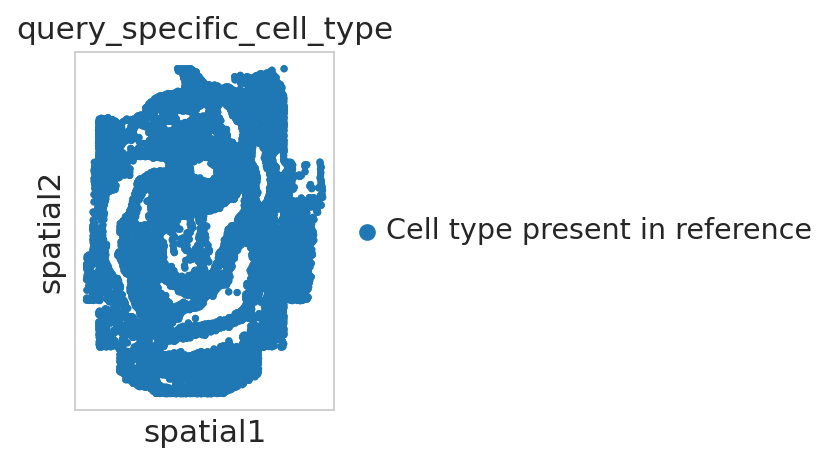

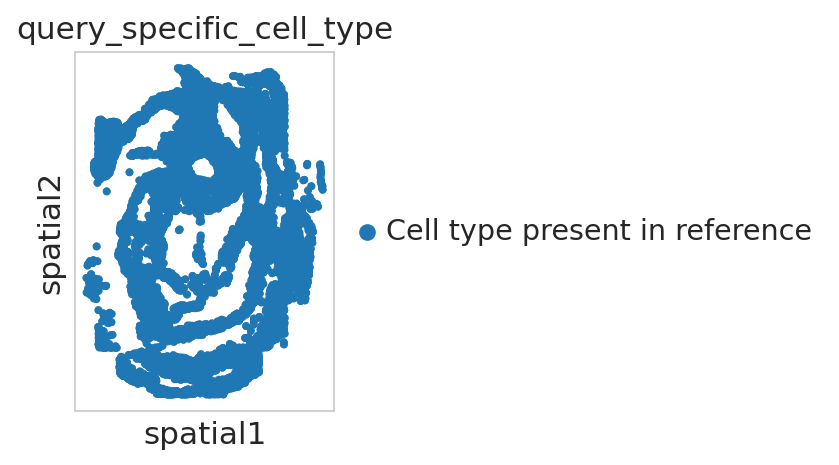

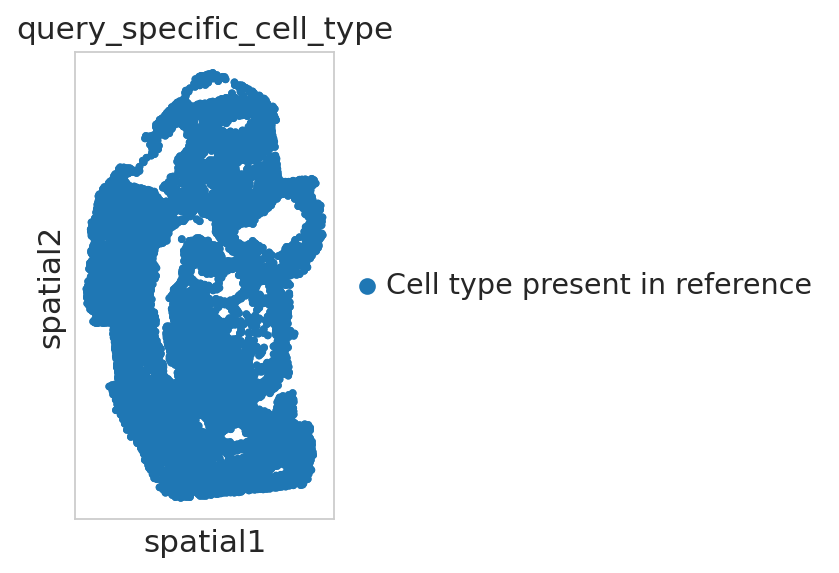

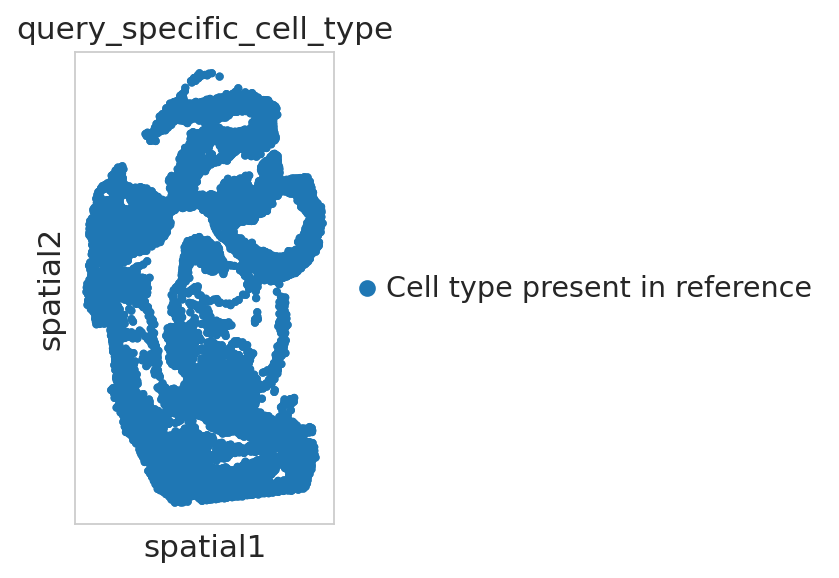

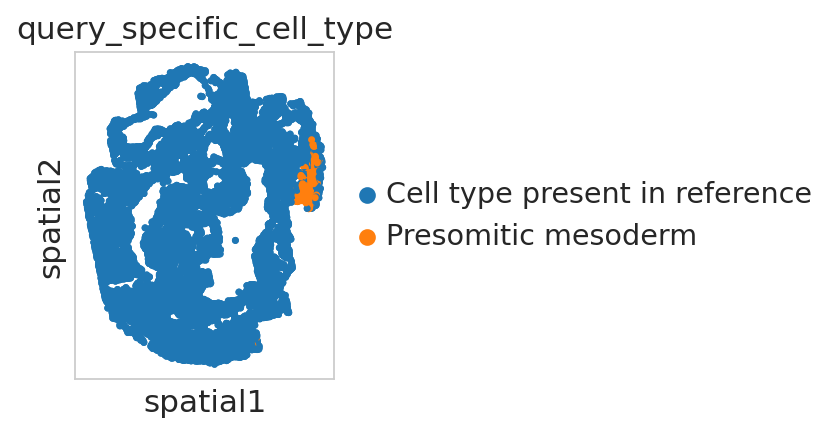

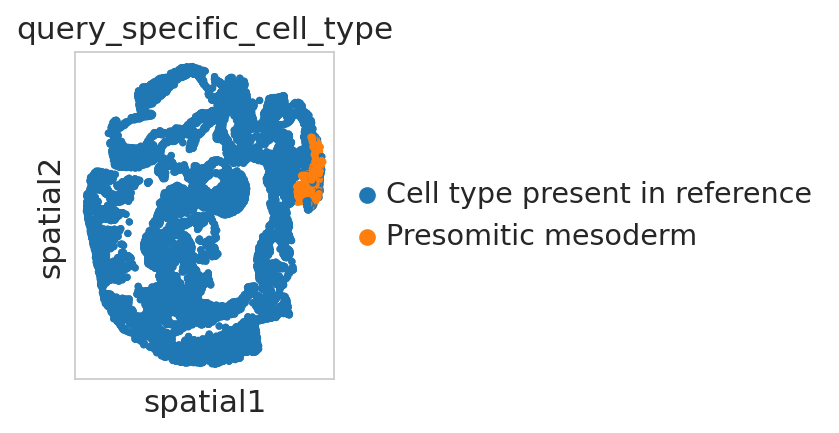

In [59]:
print(f"Using dataset {dataset}_imputed.")
print(f"Number of nodes (cells): {adata.X.shape[0]}")
print(f"Number of node features (genes): {adata.X.shape[1]}")

for adata_batch in adata_batch_list:
    # Visualize cell-level annotated data in spatial space
    sq.pl.spatial_scatter(adata_batch, color="query_specific_cell_type", shape=None, figsize=(5, 5))

### 2.3 Compute Spatial Neighbor Graphs

In [60]:
for i in range(len(adata_batch_list)):
    # Compute (separate) spatial neighborhood
    sq.gr.spatial_neighbors(adata_batch_list[i],
                            coord_type="generic",
                            spatial_key=spatial_key,
                            n_neighs=n_neighbors)
    # Make adjacency matrix symmetric
    adata_batch_list[i].obsp["spatial_connectivities"] = adata_batch_list[i].obsp["spatial_connectivities"].maximum(
        adata_batch_list[i].obsp["spatial_connectivities"].T)

### 2.4 Combine Data for BBKNN Batch Integration

In [61]:
adata_bbknn = ad.concat(adata_batch_list, join="inner")

### 2.5 Combine Data for One-Shot Batch Integration

In [62]:
adata_one_shot = ad.concat(adata_batch_list, join="inner")

# Combine spatial neighborhood graphs as disconnected components
connectivities_extension_batch1 = sp.csr_matrix((adata_batch_list[0].shape[0],
                                                 (adata_batch_list[1].shape[0] +
                                                  adata_batch_list[2].shape[0] +
                                                  adata_batch_list[3].shape[0] +
                                                  adata_batch_list[4].shape[0] +
                                                  adata_batch_list[5].shape[0])))
connectivities_extension_batch2_before = sp.csr_matrix((adata_batch_list[1].shape[0],
                                                        adata_batch_list[0].shape[0]))
connectivities_extension_batch2_after = sp.csr_matrix((adata_batch_list[1].shape[0],
                                                       (adata_batch_list[2].shape[0] +
                                                        adata_batch_list[3].shape[0] +
                                                        adata_batch_list[4].shape[0] +
                                                        adata_batch_list[5].shape[0])))
connectivities_extension_batch3_before = sp.csr_matrix((adata_batch_list[2].shape[0],
                                                        (adata_batch_list[0].shape[0] +
                                                         adata_batch_list[1].shape[0])))
connectivities_extension_batch3_after = sp.csr_matrix((adata_batch_list[2].shape[0],
                                                       (adata_batch_list[3].shape[0] +
                                                        adata_batch_list[4].shape[0] +
                                                        adata_batch_list[5].shape[0])))
connectivities_extension_batch4_before = sp.csr_matrix((adata_batch_list[3].shape[0],
                                                        (adata_batch_list[0].shape[0] +
                                                         adata_batch_list[1].shape[0] +
                                                         adata_batch_list[2].shape[0])))
connectivities_extension_batch4_after = sp.csr_matrix((adata_batch_list[3].shape[0],
                                                       (adata_batch_list[4].shape[0] +
                                                        adata_batch_list[5].shape[0])))
connectivities_extension_batch5_before = sp.csr_matrix((adata_batch_list[4].shape[0],
                                                        (adata_batch_list[0].shape[0] +
                                                         adata_batch_list[1].shape[0] +
                                                         adata_batch_list[2].shape[0] +
                                                         adata_batch_list[3].shape[0])))
connectivities_extension_batch5_after = sp.csr_matrix((adata_batch_list[4].shape[0],
                                                       adata_batch_list[5].shape[0]))
connectivities_extension_batch6 = sp.csr_matrix((adata_batch_list[5].shape[0],
                                                 (adata_batch_list[0].shape[0] +
                                                  adata_batch_list[1].shape[0] +
                                                  adata_batch_list[2].shape[0] +
                                                  adata_batch_list[3].shape[0] +
                                                  adata_batch_list[4].shape[0])))

connectivities_batch1 = sp.hstack((adata_batch_list[0].obsp["spatial_connectivities"],
                                   connectivities_extension_batch1))
connectivities_batch2 = sp.hstack((connectivities_extension_batch2_before,
                                   adata_batch_list[1].obsp["spatial_connectivities"],
                                   connectivities_extension_batch2_after))
connectivities_batch3 = sp.hstack((connectivities_extension_batch3_before,
                                   adata_batch_list[2].obsp["spatial_connectivities"],
                                   connectivities_extension_batch3_after))
connectivities_batch4 = sp.hstack((connectivities_extension_batch4_before,
                                   adata_batch_list[3].obsp["spatial_connectivities"],
                                   connectivities_extension_batch4_after))
connectivities_batch5 = sp.hstack((connectivities_extension_batch5_before,
                                   adata_batch_list[4].obsp["spatial_connectivities"],
                                   connectivities_extension_batch5_after))
connectivities_batch6 = sp.hstack((connectivities_extension_batch6,
                                   adata_batch_list[5].obsp["spatial_connectivities"]))

connectivities = sp.vstack((connectivities_batch1,
                            connectivities_batch2,
                            connectivities_batch3,
                            connectivities_batch4,
                            connectivities_batch5,
                            connectivities_batch6))

adata_one_shot.obsp["spatial_connectivities"] = connectivities

### 2.6 Combine Data for Query-to-Reference Mapping

In [63]:
# Reference
adata_reference = ad.concat(adata_batch_list[:-2], join="inner")

# Combine spatial neighborhood graphs as disconnected components
connectivities_extension_batch1 = sp.csr_matrix((adata_batch_list[0].shape[0],
                                                 (adata_batch_list[1].shape[0] +
                                                  adata_batch_list[2].shape[0] +
                                                  adata_batch_list[3].shape[0])))
connectivities_extension_batch2_before = sp.csr_matrix((adata_batch_list[1].shape[0],
                                                        adata_batch_list[0].shape[0]))
connectivities_extension_batch2_after = sp.csr_matrix((adata_batch_list[1].shape[0],
                                                       (adata_batch_list[2].shape[0] +
                                                        adata_batch_list[3].shape[0])))
connectivities_extension_batch3_before = sp.csr_matrix((adata_batch_list[2].shape[0],
                                                        (adata_batch_list[0].shape[0] +
                                                         adata_batch_list[1].shape[0])))
connectivities_extension_batch3_after = sp.csr_matrix((adata_batch_list[2].shape[0],
                                                       (adata_batch_list[3].shape[0])))
connectivities_extension_batch4 = sp.csr_matrix((adata_batch_list[3].shape[0],
                                                 (adata_batch_list[0].shape[0] +
                                                  adata_batch_list[1].shape[0] +
                                                  adata_batch_list[2].shape[0])))

connectivities_batch1 = sp.hstack((adata_batch_list[0].obsp["spatial_connectivities"],
                                   connectivities_extension_batch1))
connectivities_batch2 = sp.hstack((connectivities_extension_batch2_before,
                                   adata_batch_list[1].obsp["spatial_connectivities"],
                                   connectivities_extension_batch2_after))
connectivities_batch3 = sp.hstack((connectivities_extension_batch3_before,
                                   adata_batch_list[2].obsp["spatial_connectivities"],
                                   connectivities_extension_batch3_after))
connectivities_batch4 = sp.hstack((connectivities_extension_batch4,
                                   adata_batch_list[3].obsp["spatial_connectivities"]))

connectivities = sp.vstack((connectivities_batch1,
                            connectivities_batch2,
                            connectivities_batch3,
                            connectivities_batch4))

adata_reference.obsp["spatial_connectivities"] = connectivities

In [64]:
# Query
adata_query = ad.concat(adata_batch_list[-2:], join="inner")

# Combine spatial neighborhood graphs as disconnected components
connectivities_extension_batch5 = sp.csr_matrix((adata_batch_list[4].shape[0],
                                                 (adata_batch_list[5].shape[0])))
connectivities_extension_batch6 = sp.csr_matrix((adata_batch_list[5].shape[0],
                                                 (adata_batch_list[4].shape[0])))

connectivities_batch5 = sp.hstack((adata_batch_list[4].obsp["spatial_connectivities"],
                                   connectivities_extension_batch5))
connectivities_batch6 = sp.hstack((connectivities_extension_batch6,
                                   adata_batch_list[5].obsp["spatial_connectivities"]))

connectivities = sp.vstack((connectivities_batch5,
                            connectivities_batch6))

adata_query.obsp["spatial_connectivities"] = connectivities

In [65]:
adata_reference_query = adata_one_shot.copy()

reference_batches = adata_reference.obs["batch"].unique().tolist()
query_batches = adata_query.obs["batch"].unique().tolist()
adata_reference_query.obs["mapping_entity"] = None
adata_reference_query.obs.loc[adata_reference_query.obs["batch"].isin(reference_batches), "mapping_entity"] = "reference"
adata_reference_query.obs.loc[adata_reference_query.obs["batch"].isin(query_batches), "mapping_entity"] = "query"

## 3. Autotalker Model

### 3.1 Prepare Gene Program Mask

In [66]:
nichenet_gp_dict = extract_gp_dict_from_nichenet_ligand_target_mx(
    keep_target_ratio=0.01,
    load_from_disk=True,
    save_to_disk=False,
    file_path=nichenet_ligand_target_mx_file_path)

In [67]:
omnipath_gp_dict = extract_gp_dict_from_omnipath_lr_interactions(
    min_curation_effort=0,
    load_from_disk=False,
    save_to_disk=True,
    file_path=omnipath_lr_interactions_file_path)

In [68]:
mebocost_gp_dict = extract_gp_dict_from_mebocost_es_interactions(
    dir_path=f"{gp_data_folder_path}/metabolite_enzyme_sensor_gps/",
    species="mouse",
    genes_uppercase=True)

In [69]:
# Combine gene programs into one dictionary
combined_gp_dict = dict(nichenet_gp_dict)
combined_gp_dict.update(omnipath_gp_dict)
combined_gp_dict.update(mebocost_gp_dict)

In [70]:
# Filter and combine gene programs
combined_new_gp_dict = filter_and_combine_gp_dict_gps(
    gp_dict=combined_gp_dict,
    gp_filter_mode="subset",
    combine_overlap_gps=True,
    overlap_thresh_source_genes=0.9,
    overlap_thresh_target_genes=0.9,
    overlap_thresh_genes=0.9,
    verbose=True)

print(f"Number of gene programs before filtering and combining: {len(combined_gp_dict)}.")
print(f"Number of gene programs after filtering and combining: {len(combined_new_gp_dict)}.")

Removing GP 'CTF1_ligand_receptor_GP' as it is a subset of GP 'CTF1_ligand_targetgenes_GP'.
Removing GP 'LEP_ligand_receptor_GP' as it is a subset of GP 'LEP_ligand_targetgenes_GP'.
Removing GP 'IL4_ligand_receptor_GP' as it is a subset of GP 'IL4_ligand_targetgenes_GP'.
Removing GP 'IL12A_ligand_receptor_GP' as it is a subset of GP 'IL12A_ligand_targetgenes_GP'.
Removing GP 'IL23A_ligand_receptor_GP' as it is a subset of GP 'IL23A_ligand_targetgenes_GP'.
Removing GP 'CSF2_ligand_receptor_GP' as it is a subset of GP 'CSF2_ligand_targetgenes_GP'.
Removing GP 'IL21_ligand_receptor_GP' as it is a subset of GP 'IL21_ligand_targetgenes_GP'.
Removing GP 'TSLP_ligand_receptor_GP' as it is a subset of GP 'TSLP_ligand_targetgenes_GP'.
Removing GP 'GH2_ligand_receptor_GP' as it is a subset of GP 'GH2_ligand_targetgenes_GP'.
Removing GP 'EGF_ligand_receptor_GP' as it is a subset of GP 'EGF_ligand_targetgenes_GP'.
Removing GP 'IL10_ligand_receptor_GP' as it is a subset of GP 'IL10_ligand_targetgen

In [71]:
for adata in adata_batch_list + [
    adata_one_shot, adata_reference, adata_query, adata_reference_query]:
    # Add the gene program dictionary as binary masks to the adata for model training
    add_gps_from_gp_dict_to_adata(
        gp_dict=combined_new_gp_dict,
        adata=adata,
        genes_uppercase=True,
        gp_targets_mask_key="autotalker_gp_targets",
        gp_sources_mask_key="autotalker_gp_sources",
        gp_names_key="autotalker_gp_names",
        min_genes_per_gp=1,
        min_source_genes_per_gp=0,
        min_target_genes_per_gp=0,
        max_genes_per_gp=None,
        max_source_genes_per_gp=None,
        max_target_genes_per_gp=None,
        filter_genes_not_in_masks=False)

# Determine dimensionality of hidden encoder
n_hidden_encoder = len(adata_one_shot.uns["autotalker_gp_names"])

# Summarize gene programs
print(f"Number of gene programs with probed genes: {len(adata_one_shot.uns['autotalker_gp_names'])}.")
print(f"Example gene programs: {random.sample(list(adata_one_shot.uns['autotalker_gp_names']), 5)}.")
print(f"Number of gene program target genes: {adata_one_shot.varm['autotalker_gp_targets'].sum()}.")
print(f"Number of gene program source genes: {adata_one_shot.varm['autotalker_gp_sources'].sum()}.")

Number of gene programs with probed genes: 1064.
Example gene programs: ['Testosterone_metabolite_enzyme_sensor_GP', 'Glutathione_metabolite_enzyme_sensor_GP', 'TG_ligand_targetgenes_GP', 'TFRC_ligand_receptor_GP', 'HDC_ligand_targetgenes_GP'].
Number of gene program target genes: 53704.
Number of gene program source genes: 939.


### 3.2 BBKNN Batch Integration Baseline

#### 3.2.1 Initialize, Train & Save Batch-Specific Models

In [ ]:
latent_bbknn_list = []
for i in range(len(adata_batch_list)):
    # Initialize model
    model = Autotalker(adata_batch_list[i],
                       counts_key=counts_key,
                       adj_key=adj_key,
                       condition_key=condition_key,
                       cond_embed_injection=["encoder",
                                             "gene_expr_decoder",
                                             "graph_decoder"],
                       n_cond_embed=n_cond_embed,
                       gp_names_key=gp_names_key,
                       active_gp_names_key=active_gp_names_key,
                       gp_targets_mask_key=gp_targets_mask_key,
                       gp_sources_mask_key=gp_sources_mask_key,
                       latent_key=latent_key,
                       active_gp_thresh_ratio=active_gp_thresh_ratio,
                       gene_expr_recon_dist=gene_expr_recon_dist,
                       n_hidden_encoder=n_hidden_encoder,
                       log_variational=log_variational)
    print("")
    
    # Train model
    model.train(n_epochs,
                n_epochs_all_gps=n_epochs_all_gps,
                lr=lr,
                lambda_edge_recon=lambda_edge_recon,
                lambda_gene_expr_recon=lambda_gene_expr_recon,
                verbose=True)
    print("")
    
    # Save trained model
    model.save(dir_path=model_artifacts_folder_path + f"/bbknn_batch{i+1}",
               overwrite=True,
               save_adata=True,
               adata_file_name=f"{dataset}.h5ad")
    
    latent_bbknn_current_batch = model.get_latent_representation(
        adata=adata_batch_list[i],
        counts_key=counts_key,
        condition_key=condition_key,
        only_active_gps=False)
    
    latent_bbknn_list.append(latent_bbknn_current_batch)
    
adata_bbknn.obsm[latent_key] = np.vstack(latent_bbknn_list)

# Store adata to disk
adata_bbknn.write(f"{model_artifacts_folder_path}/adata_bbknn.h5ad")

--- INITIALIZING NEW NETWORK MODULE: VARIATIONAL GENE PROGRAM GRAPH AUTOENCODER ---
LOSS -> include_edge_recon_loss: True, include_gene_expr_recon_loss: True, gene_expr_recon_dist: nb
NODE LABEL METHOD -> one-hop-attention
ACTIVE GP THRESHOLD RATIO -> 0.03
LOG VARIATIONAL -> False
CONDITIONAL EMBEDDING INJECTION -> ['encoder', 'gene_expr_decoder', 'graph_decoder']
GRAPH ENCODER -> n_input: 4000, n_cond_embed_input: 3, n_hidden: 1064, n_latent: 1064, n_addon_latent: 0, conv_layer: gcnconv, n_attention_heads: 0, dropout_rate: 0.0
DOT PRODUCT GRAPH DECODER -> n_cond_embed_input: 3, n_output: 1064, dropout_rate: 0.0
3
MASKED GENE EXPRESSION DECODER -> n_input: 1064, n_cond_embed_input: 3, n_addon_input: 0, n_output: 8000

--- INITIALIZING TRAINER ---
Number of training nodes: 8915
Number of validation nodes: 990
Number of training edges: 20674
Number of validation edges: 2297

--- MODEL TRAINING ---
Epoch 1/40 |--------------------| 2.5% val_auroc_score: 0.5054; val_auprc_score: 0.5027; va

In [ ]:
# Read adata from disk
adata_bbknn = sc.read_h5ad(f"{srt_data_gold_folder_path}/{dataset}_bbknn.h5ad")
adata_bbknn.write(f"{model_artifacts_folder_path}/adata_bbknn.h5ad")
adata_bbknn = sc.read_h5ad(f"{model_artifacts_folder_path}/adata_bbknn.h5ad")

#### 3.2.2 Correct Batch Effects with BBKNN

In [ ]:
# Compute batch-corrected latent nearest neighbor graph
bbknn.bbknn(adata=adata_bbknn,
            batch_key=condition_key,
            use_rep=latent_key)

adata_bbknn.obsp[f"{latent_knng_key}_connectivities"] = (
    adata_bbknn.obsp["connectivities"])

adata_bbknn.obsp[f"{latent_knng_key}_distances"] = (
    adata_bbknn.obsp["distances"])

#### 3.2.3 Analyze Latent Space

In [ ]:
# Compute spatial nearest neighbor graph
sc.pp.neighbors(adata_bbknn, use_rep=latent_key, key_added=spatial_knng_key)

In [ ]:
# Use batch-corrected latent space for UMAP generation
sc.tl.umap(adata_bbknn)

In [ ]:
# Plot UMAP with batch annotations
fig = sc.pl.umap(adata_bbknn,
                 color=[condition_key],
                 legend_fontsize=12,
                 return_fig=True)
plt.title("BBKNN Integrated: Latent Space Batch Annotations", size=20, pad=15)
fig.savefig(f"{figure_folder_path}/latent_batches_bbknn.png",
            bbox_inches="tight")

In [ ]:
# Plot UMAP with cell type annotations
fig = sc.pl.umap(adata_bbknn,
                 color=[cell_type_key],
                 return_fig=True)
plt.title("BBKNN Integrated: Latent Space Cell Type Annotations", size=20, pad=15)
fig.savefig(f"{figure_folder_path}/latent_cell_types_bbknn.png",
            bbox_inches="tight")

#### 3.3.4 Compute Metrics

In [ ]:
metrics_dict_bbknn = {}

metrics_dict_bbknn["cad"] = compute_cad(
    adata=adata_bbknn,
    cell_type_key=cell_type_key,
    spatial_knng_key=spatial_knng_key,
    latent_knng_key=latent_knng_key)

metrics_dict_bbknn["rclisi"] = compute_rclisi(
    adata=adata_bbknn,
    cell_type_key=cell_type_key,
    spatial_knng_key=spatial_knng_key,
    latent_knng_key=latent_knng_key)
    
metrics_dict_bbknn["batch_asw"] = scib.me.silhouette_batch(
    adata=adata_bbknn,
    batch_key=condition_key,
    label_key=cell_type_key,
    embed="X_umap")

# knn output
metrics_dict_bbknn["ilisi"] = scib.me.ilisi_graph(
    adata=adata_bbknn,
    batch_key=condition_key,
    type_="knn")

"""
metrics_dict_bbknn["kbet"] = scib.me.kBET(
    adata=adata_bbknn,
    batch_key=condition_key,
    label_key=cell_type_key,
    type_="knn")
"""

print(metrics_dict_bbknn)

# Store to disk
with open(f"{model_artifacts_folder_path}/metrics_bbknn.pickle", "wb") as f:
    pickle.dump(metrics_dict_bbknn, f)

### 3.3 One-Shot Batch Integration

#### 3.3.1 Initialize, Train & Save Model

In [72]:
# Initialize model
model = Autotalker(adata_one_shot,
                   counts_key=counts_key,
                   adj_key=adj_key,
                   condition_key=condition_key,
                   cond_embed_injection=["encoder",
                                         "gene_expr_decoder",
                                         "graph_decoder"],
                   n_cond_embed=n_cond_embed,
                   gp_names_key=gp_names_key,
                   active_gp_names_key=active_gp_names_key,
                   gp_targets_mask_key=gp_targets_mask_key,
                   gp_sources_mask_key=gp_sources_mask_key,
                   latent_key=latent_key,
                   active_gp_thresh_ratio=active_gp_thresh_ratio,
                   gene_expr_recon_dist=gene_expr_recon_dist,
                   n_hidden_encoder=n_hidden_encoder,
                   log_variational=log_variational)

--- INITIALIZING NEW NETWORK MODULE: VARIATIONAL GENE PROGRAM GRAPH AUTOENCODER ---
LOSS -> include_edge_recon_loss: True, include_gene_expr_recon_loss: True, gene_expr_recon_dist: nb
NODE LABEL METHOD -> one-hop-attention
ACTIVE GP THRESHOLD RATIO -> 0.03
LOG VARIATIONAL -> False
CONDITIONAL EMBEDDING INJECTION -> ['encoder', 'gene_expr_decoder', 'graph_decoder']
GRAPH ENCODER -> n_input: 4000, n_cond_embed_input: 3, n_hidden: 1064, n_latent: 1064, n_addon_latent: 0, conv_layer: gcnconv, n_attention_heads: 0, dropout_rate: 0.0
DOT PRODUCT GRAPH DECODER -> n_cond_embed_input: 3, n_output: 1064, dropout_rate: 0.0
3
MASKED GENE EXPRESSION DECODER -> n_input: 1064, n_cond_embed_input: 3, n_addon_input: 0, n_output: 8000


In [73]:
# Train model
model.train(n_epochs,
            n_epochs_all_gps=n_epochs_all_gps,
            lr=lr,
            lambda_edge_recon=lambda_edge_recon,
            lambda_gene_expr_recon=lambda_gene_expr_recon,
            verbose=True)

--- INITIALIZING TRAINER ---
Number of training nodes: 46898
Number of validation nodes: 5211
Number of training edges: 108918
Number of validation edges: 12102

--- MODEL TRAINING ---
Epoch 1/40 |--------------------| 2.5% val_auroc_score: 0.6838; val_auprc_score: 0.6126; val_best_acc_score: 0.6078; val_best_f1_score: 0.7183; train_kl_reg_loss: 0.0540; train_edge_recon_loss: 0.2580; train_gene_expr_recon_loss: 7.4441; train_group_lasso_reg_loss: 0.0000; train_global_loss: 7.7561; train_optim_loss: 7.7561; val_kl_reg_loss: 0.0467; val_edge_recon_loss: 0.1636; val_gene_expr_recon_loss: 6.2817; val_group_lasso_reg_loss: 0.0000; val_global_loss: 6.4920; val_optim_loss: 6.4920
Epoch 2/40 |█-------------------| 5.0% val_auroc_score: 0.8192; val_auprc_score: 0.7346; val_best_acc_score: 0.6917; val_best_f1_score: 0.7643; train_kl_reg_loss: 0.0690; train_edge_recon_loss: 0.0671; train_gene_expr_recon_loss: 5.9477; train_group_lasso_reg_loss: 0.0000; train_global_loss: 6.0837; train_optim_loss:

In [80]:
# Save trained model
model.save(dir_path=model_artifacts_folder_path + "/oneshot",
           overwrite=True,
           save_adata=True,
           adata_file_name=f"{dataset}.h5ad")

#### 3.3.2 Load Model

In [81]:
if load_timestamp is not None:
    model_artifacts_load_folder_path = f"../artifacts/{dataset}/batch_integration/{load_timestamp}"
else:
    model_artifacts_load_folder_path = model_artifacts_folder_path

# Load trained model
model = Autotalker.load(dir_path=model_artifacts_folder_path + "/oneshot",
                        adata=None,
                        adata_file_name=f"{dataset}.h5ad",
                        gp_names_key="autotalker_gp_names")

--- INITIALIZING NEW NETWORK MODULE: VARIATIONAL GENE PROGRAM GRAPH AUTOENCODER ---
LOSS -> include_edge_recon_loss: True, include_gene_expr_recon_loss: True, gene_expr_recon_dist: nb
NODE LABEL METHOD -> one-hop-attention
ACTIVE GP THRESHOLD RATIO -> 0.03
LOG VARIATIONAL -> False
CONDITIONAL EMBEDDING INJECTION -> ['encoder', 'gene_expr_decoder', 'graph_decoder']
GRAPH ENCODER -> n_input: 4000, n_cond_embed_input: 3, n_hidden: 1064, n_latent: 1064, n_addon_latent: 0, conv_layer: gcnconv, n_attention_heads: 0, dropout_rate: 0.0
DOT PRODUCT GRAPH DECODER -> n_cond_embed_input: 3, n_output: 1064, dropout_rate: 0.0
3
MASKED GENE EXPRESSION DECODER -> n_input: 1064, n_cond_embed_input: 3, n_addon_input: 0, n_output: 8000


#### 3.3.3 Visualize Latent Space

In [82]:
# Use Autotalker latent space for UMAP generation
sc.pp.neighbors(model.adata, use_rep=latent_key)
sc.tl.umap(model.adata)

/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:163: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))


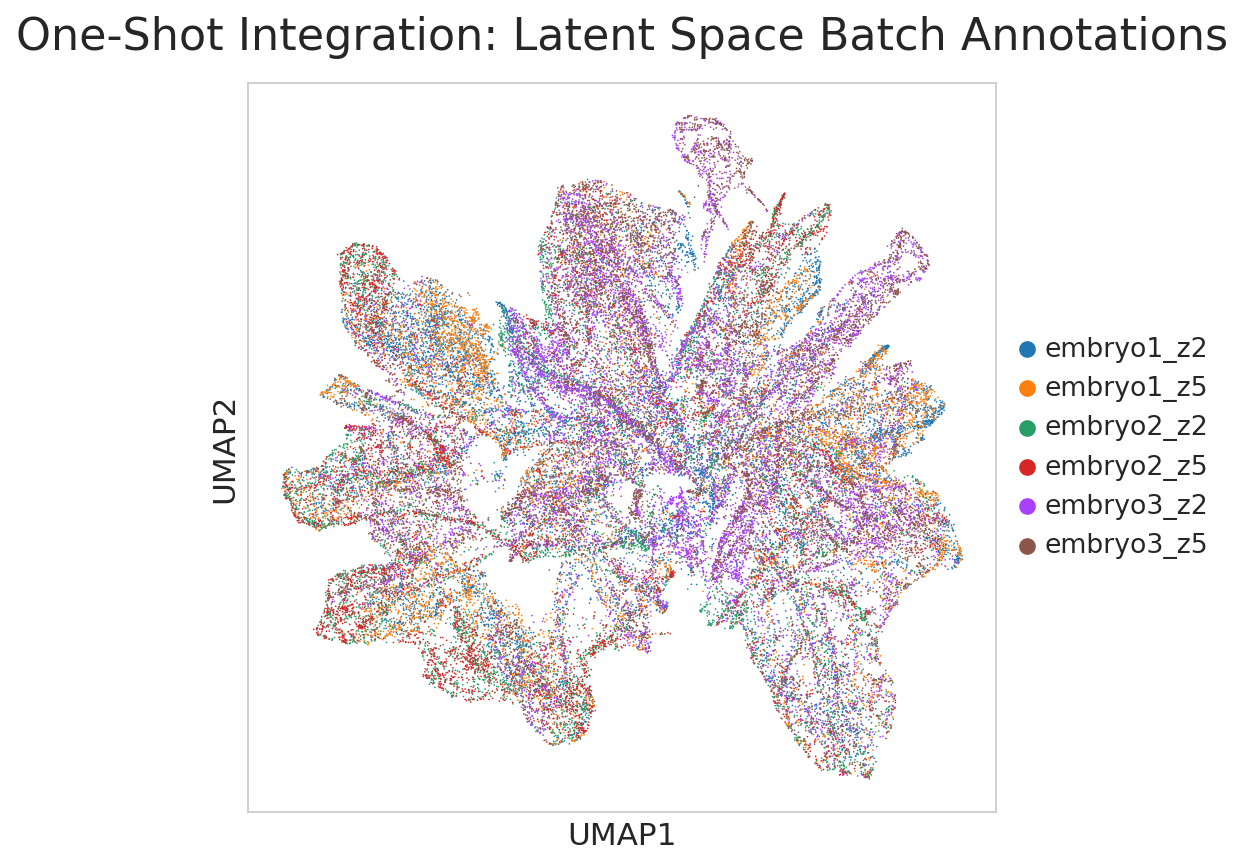

In [89]:
# Plot UMAP with batch annotations
fig = sc.pl.umap(model.adata,
                 color=[condition_key],
                 legend_fontsize=12,
                 return_fig=True)
plt.title("One-Shot Integration: Latent Space Batch Annotations", size=20, pad=15)
fig.savefig(f"{figure_folder_path}/latent_batches_oneshot.png",
            bbox_inches="tight")

/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:163: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))


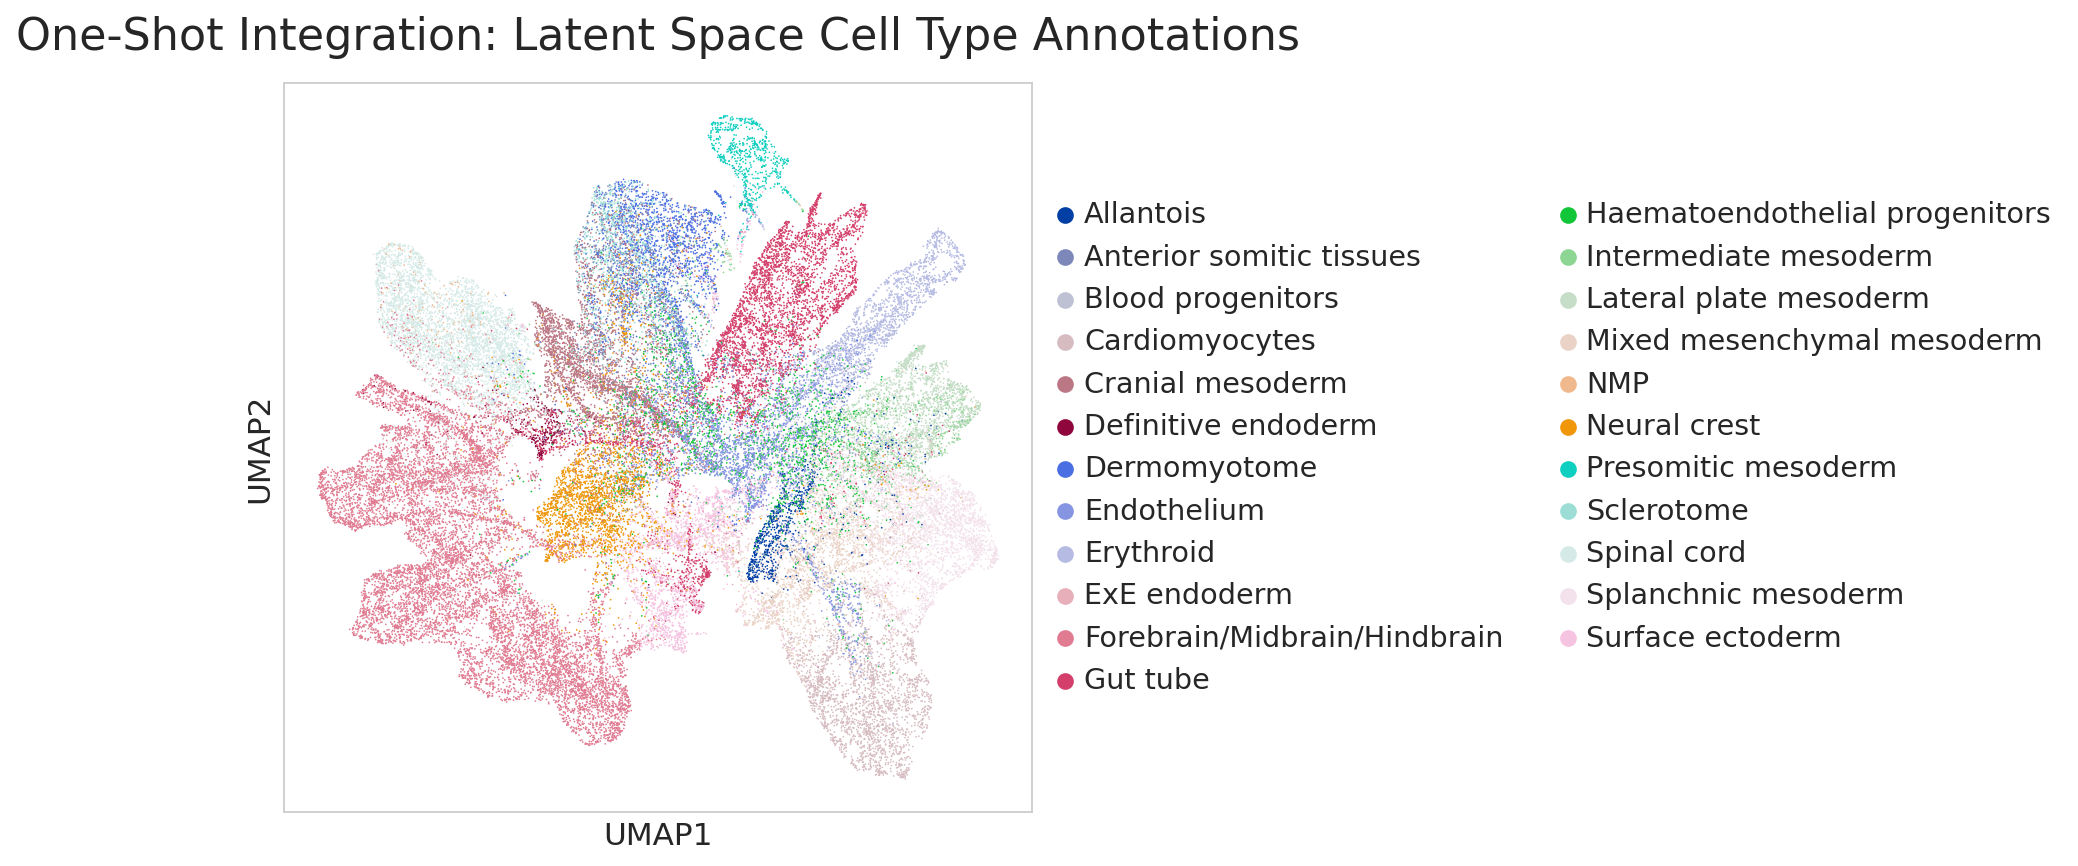

In [88]:
# Plot UMAP with cell type annotations
fig = sc.pl.umap(model.adata,
                 color=[cell_type_key],
                 return_fig=True)
plt.title("One-Shot Integration: Latent Space Cell Type Annotations", size=20, pad=15)
fig.savefig(f"{figure_folder_path}/latent_cell_types_oneshot.png",
            bbox_inches="tight")

#### 3.3.4 Compute Metrics

In [85]:
# Store computed latent nearest neighbor graph in latent connectivities
model.adata.obsp[f"{latent_knng_key}_connectivities"] = (
    model.adata.obsp["connectivities"])
model.adata.obsp[f"{latent_knng_key}_distances"] = (
    model.adata.obsp["distances"])

# Compute spatial nearest neighbor graph
sc.pp.neighbors(model.adata, use_rep=spatial_key, key_added=spatial_knng_key)

In [86]:
# Compute metrics
metrics_dict_oneshot = {}

# Spatial conservation metrics
metrics_dict_oneshot["cad"] = compute_cad(
    adata=model.adata,
    cell_type_key=cell_type_key,
    spatial_knng_key=spatial_knng_key,
    latent_knng_key=latent_knng_key)
metrics_dict_oneshot["rclisi"] = compute_rclisi(
    adata=model.adata,
    cell_type_key=cell_type_key,
    spatial_knng_key=spatial_knng_key,
    latent_knng_key=latent_knng_key)
    
# Batch correction metrics
metrics_dict_oneshot["batch_asw"] = scib.me.silhouette_batch(
    adata=model.adata,
    batch_key=condition_key,
    label_key=cell_type_key,
    embed="X_umap")
metrics_dict_oneshot["ilisi"] = scib.me.ilisi_graph(
    adata=model.adata,
    batch_key=condition_key,
    type_="knn")
"""
metrics_dict_bbknn["kbet"] = scib.me.kBET(
    adata=model.adata,
    batch_key=condition_key,
    label_key=cell_type_key,
    type_="knn")
"""

print(metrics_dict_oneshot)

# Store metrics to disk
with open(f"{model_artifacts_folder_path}/metrics_oneshot.pickle", "wb") as f:
    pickle.dump(metrics_dict_oneshot, f)

Using precomputed spatial nearest neighbor graph...
Using precomputed latent nearest neighbor graph...
Using precomputed spatial nearest neighbor graph...
Using precomputed latent nearest neighbor graph...
mean silhouette per group:                                 silhouette_score
group                                           
Allantois                               0.809889
Anterior somitic tissues                0.869788
Blood progenitors                       0.640127
Cardiomyocytes                          0.906408
Cranial mesoderm                        0.905892
Definitive endoderm                     0.813133
Dermomyotome                            0.858010
Endothelium                             0.896403
Erythroid                               0.894365
ExE endoderm                            0.651225
Forebrain/Midbrain/Hindbrain            0.930477
Gut tube                                0.833766
Haematoendothelial progenitors          0.943172
Intermediate mesoderm           

#### 3.3.5 Visualize Conditional Embedding

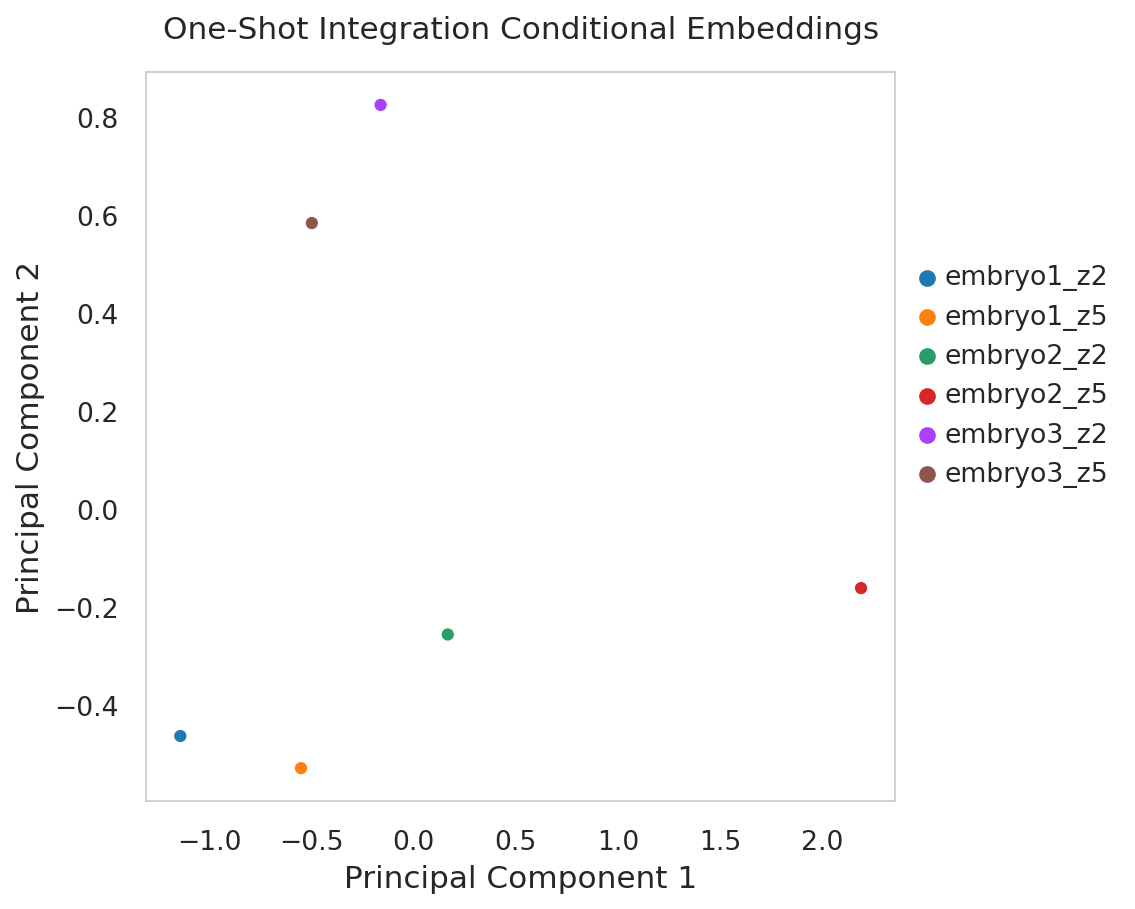

In [90]:
# Get conditional embeddings
cond_embed = model.get_conditional_embeddings()
cond = model.adata.obs["batch"].unique()

# Get top 2 principal components and plot them
pca = KernelPCA(n_components=2, kernel="linear")
cond_embed_pca = pca.fit_transform(cond_embed)
sns.scatterplot(x=cond_embed_pca[:, 0], 
                y=cond_embed_pca[:, 1], 
                hue=cond)
plt.title("One-Shot Integration Conditional Embeddings", pad=15)
plt.xlabel("Principal Component 1")
plt.xticks(fontsize=12)
plt.ylabel ("Principal Component 2")
plt.yticks(fontsize=12)
plt.legend(bbox_to_anchor=(1.02, 0.75),
           loc=2,
           borderaxespad=0.,
           fontsize=12,
           frameon=False)
plt.savefig(f"{figure_folder_path}/cond_embed_oneshot.png",
            bbox_inches="tight")

### 3.4 Query-to-Reference Mapping

#### 3.4.1 Building the Reference

##### 3.4.1.1 Initialize, Train & Save Model

In [91]:
# Initialize model
model = Autotalker(adata_reference,
                   counts_key=counts_key,
                   adj_key=adj_key,
                   condition_key=condition_key,
                   cond_embed_injection=["encoder",
                                         "gene_expr_decoder",
                                         "graph_decoder"],
                   n_cond_embed=n_cond_embed,
                   gp_names_key=gp_names_key,
                   active_gp_names_key=active_gp_names_key,
                   gp_targets_mask_key=gp_targets_mask_key,
                   gp_sources_mask_key=gp_sources_mask_key,
                   latent_key=latent_key,
                   active_gp_thresh_ratio=active_gp_thresh_ratio,
                   gene_expr_recon_dist=gene_expr_recon_dist,
                   n_hidden_encoder=n_hidden_encoder,
                   log_variational=log_variational)

--- INITIALIZING NEW NETWORK MODULE: VARIATIONAL GENE PROGRAM GRAPH AUTOENCODER ---
LOSS -> include_edge_recon_loss: True, include_gene_expr_recon_loss: True, gene_expr_recon_dist: nb
NODE LABEL METHOD -> one-hop-attention
ACTIVE GP THRESHOLD RATIO -> 0.03
LOG VARIATIONAL -> False
CONDITIONAL EMBEDDING INJECTION -> ['encoder', 'gene_expr_decoder', 'graph_decoder']
GRAPH ENCODER -> n_input: 4000, n_cond_embed_input: 3, n_hidden: 1064, n_latent: 1064, n_addon_latent: 0, conv_layer: gcnconv, n_attention_heads: 0, dropout_rate: 0.0
DOT PRODUCT GRAPH DECODER -> n_cond_embed_input: 3, n_output: 1064, dropout_rate: 0.0
3
MASKED GENE EXPRESSION DECODER -> n_input: 1064, n_cond_embed_input: 3, n_addon_input: 0, n_output: 8000


In [92]:
# Train model
model.train(n_epochs,
            n_epochs_all_gps=n_epochs_all_gps,
            lr=lr,
            lambda_edge_recon=lambda_edge_recon,
            lambda_gene_expr_recon=lambda_gene_expr_recon,
            verbose=True)

--- INITIALIZING TRAINER ---
Number of training nodes: 28379
Number of validation nodes: 3153
Number of training edges: 65815
Number of validation edges: 7312

--- MODEL TRAINING ---
Epoch 1/40 |--------------------| 2.5% val_auroc_score: 0.6960; val_auprc_score: 0.6219; val_best_acc_score: 0.6184; val_best_f1_score: 0.7238; train_kl_reg_loss: 0.0349; train_edge_recon_loss: 0.3471; train_gene_expr_recon_loss: 8.0267; train_group_lasso_reg_loss: 0.0000; train_global_loss: 8.4087; train_optim_loss: 8.4087; val_kl_reg_loss: 0.0410; val_edge_recon_loss: 0.1795; val_gene_expr_recon_loss: 6.8145; val_group_lasso_reg_loss: 0.0000; val_global_loss: 7.0351; val_optim_loss: 7.0351
Epoch 2/40 |█-------------------| 5.0% val_auroc_score: 0.6472; val_auprc_score: 0.5863; val_best_acc_score: 0.5851; val_best_f1_score: 0.7068; train_kl_reg_loss: 0.0573; train_edge_recon_loss: 0.0884; train_gene_expr_recon_loss: 6.3763; train_group_lasso_reg_loss: 0.0000; train_global_loss: 6.5220; train_optim_loss: 6

In [93]:
# Save trained model
model.save(dir_path=model_artifacts_folder_path + "/reference",
           overwrite=True,
           save_adata=True,
           adata_file_name=f"{dataset}.h5ad")

##### 3.4.1.2 Load Model

In [94]:
if load_timestamp is not None:
    model_artifacts_load_folder_path = f"../artifacts/{dataset}/batch_integration/{load_timestamp}"
else:
    model_artifacts_load_folder_path = model_artifacts_folder_path

# Load trained model
model = Autotalker.load(dir_path=model_artifacts_folder_path + "/reference",
                        adata=None,
                        adata_file_name=f"{dataset}.h5ad",
                        gp_names_key="autotalker_gp_names")

--- INITIALIZING NEW NETWORK MODULE: VARIATIONAL GENE PROGRAM GRAPH AUTOENCODER ---
LOSS -> include_edge_recon_loss: True, include_gene_expr_recon_loss: True, gene_expr_recon_dist: nb
NODE LABEL METHOD -> one-hop-attention
ACTIVE GP THRESHOLD RATIO -> 0.03
LOG VARIATIONAL -> False
CONDITIONAL EMBEDDING INJECTION -> ['encoder', 'gene_expr_decoder', 'graph_decoder']
GRAPH ENCODER -> n_input: 4000, n_cond_embed_input: 3, n_hidden: 1064, n_latent: 1064, n_addon_latent: 0, conv_layer: gcnconv, n_attention_heads: 0, dropout_rate: 0.0
DOT PRODUCT GRAPH DECODER -> n_cond_embed_input: 3, n_output: 1064, dropout_rate: 0.0
3
MASKED GENE EXPRESSION DECODER -> n_input: 1064, n_cond_embed_input: 3, n_addon_input: 0, n_output: 8000


##### 3.4.1.3 Visualize Latent Space

In [95]:
# Use Autotalker latent space for UMAP generation
sc.pp.neighbors(model.adata, use_rep=latent_key)
sc.tl.umap(model.adata)

/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:163: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))


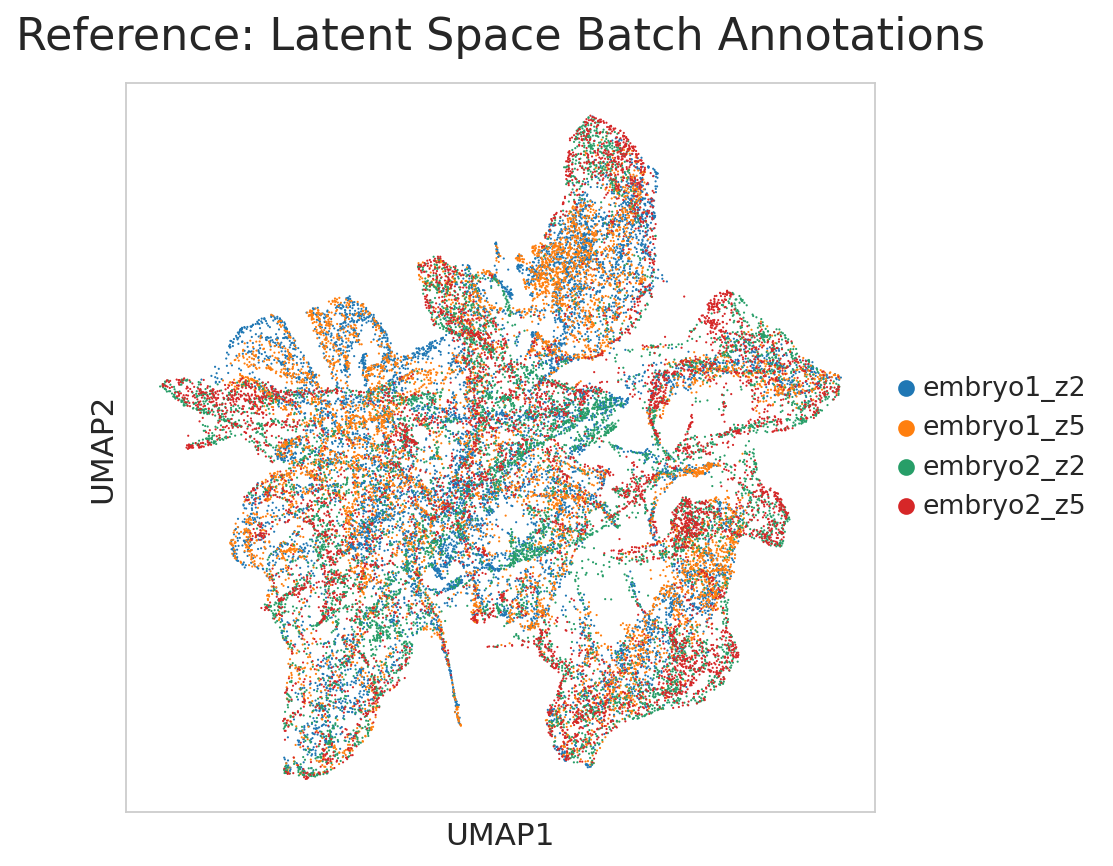

In [96]:
# Plot UMAP with batch annotations
fig = sc.pl.umap(model.adata,
                 color=[condition_key],
                 legend_fontsize=12,
                 return_fig=True)
plt.title("Reference: Latent Space Batch Annotations", size=20, pad=15)
fig.savefig(f"{figure_folder_path}/latent_batches_reference.png",
            bbox_inches="tight")

/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:163: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))


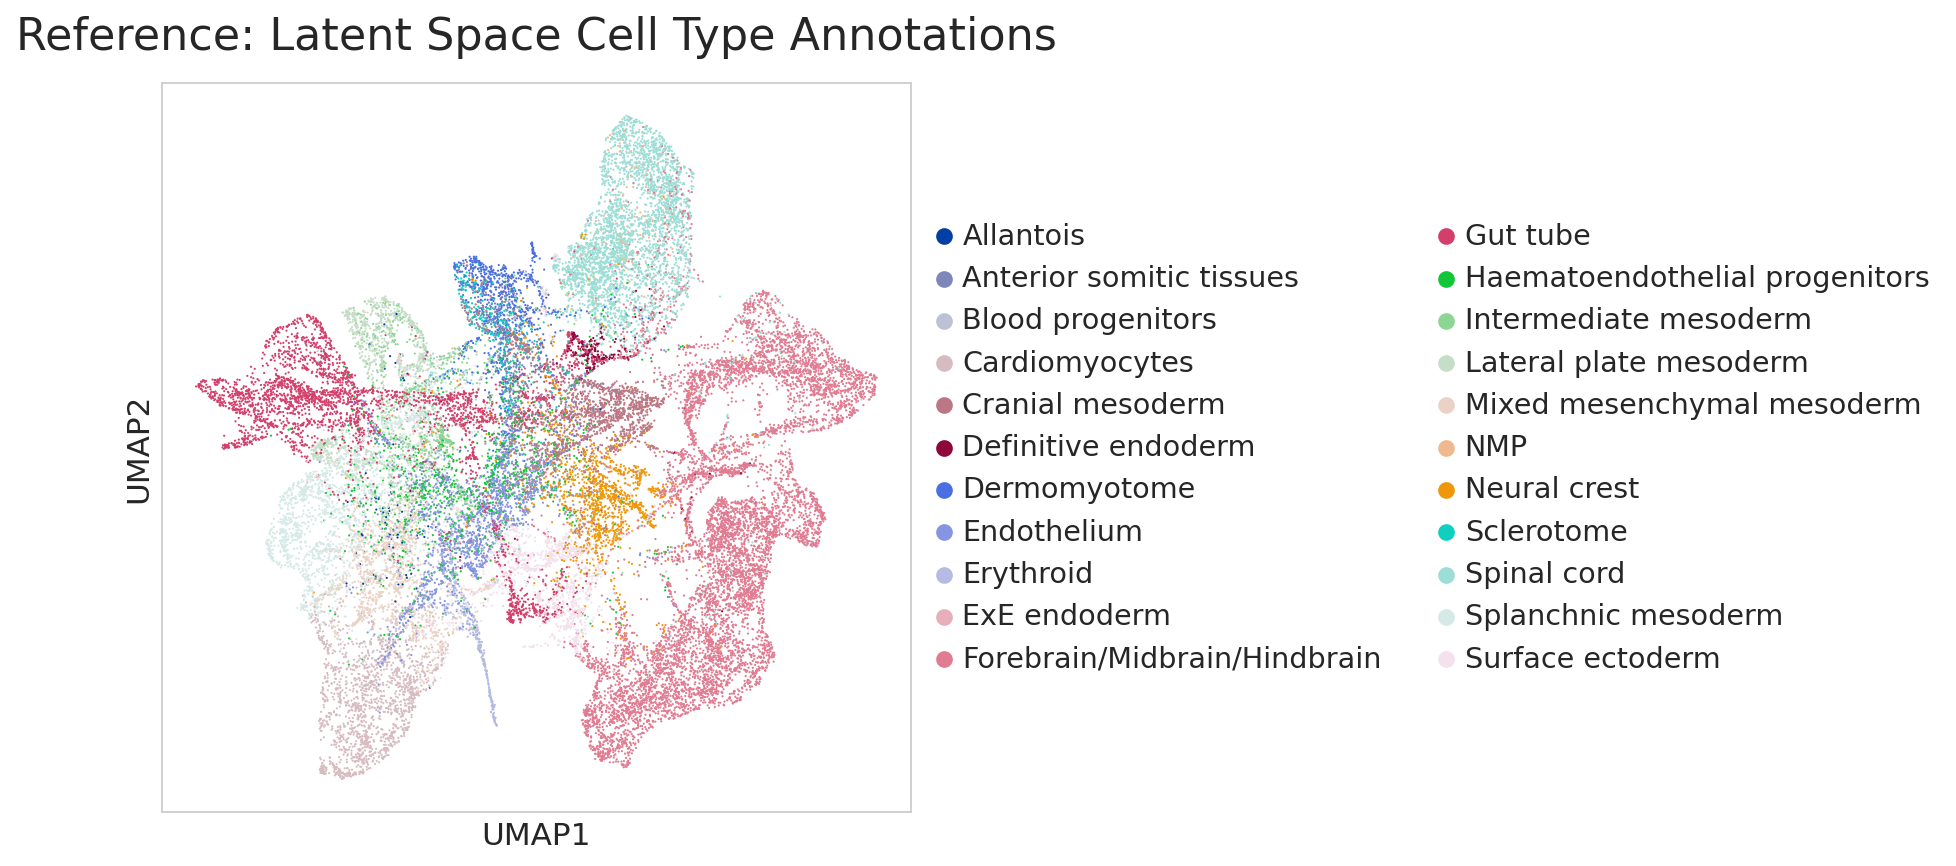

In [97]:
# Plot UMAP with cell type annotations
fig = sc.pl.umap(model.adata,
                 color=[cell_type_key],
                 return_fig=True)
plt.title("Reference: Latent Space Cell Type Annotations", size=20, pad=15)
fig.savefig(f"{figure_folder_path}/latent_cell_types_reference.png",
            bbox_inches="tight")

#### 3.4.2 Mapping the Query

##### 3.4.2.1 Initialize, Train & Save Model

In [98]:
# Load model trained on reference data for transfer learning with query data
# Freeze all weights except for conditional weights
model = Autotalker.load(dir_path=model_artifacts_folder_path + "/reference",
                        adata=adata_query,
                        adata_file_name=f"{dataset}.h5ad",
                        gp_names_key="autotalker_gp_names",
                        unfreeze_all_weights=False,
                        unfreeze_cond_embed_weights=True)

--- INITIALIZING NEW NETWORK MODULE: VARIATIONAL GENE PROGRAM GRAPH AUTOENCODER ---
LOSS -> include_edge_recon_loss: True, include_gene_expr_recon_loss: True, gene_expr_recon_dist: nb
NODE LABEL METHOD -> one-hop-attention
ACTIVE GP THRESHOLD RATIO -> 0.03
LOG VARIATIONAL -> False
CONDITIONAL EMBEDDING INJECTION -> ['encoder', 'gene_expr_decoder', 'graph_decoder']
GRAPH ENCODER -> n_input: 4000, n_cond_embed_input: 3, n_hidden: 1064, n_latent: 1064, n_addon_latent: 0, conv_layer: gcnconv, n_attention_heads: 0, dropout_rate: 0.0
DOT PRODUCT GRAPH DECODER -> n_cond_embed_input: 3, n_output: 1064, dropout_rate: 0.0
3
MASKED GENE EXPRESSION DECODER -> n_input: 1064, n_cond_embed_input: 3, n_addon_input: 0, n_output: 8000


In [99]:
# Train model
model.train(n_epochs,
            n_epochs_all_gps=n_epochs_all_gps,
            lr=query_cond_embed_lr,
            lambda_edge_recon=lambda_edge_recon,
            lambda_gene_expr_recon=lambda_gene_expr_recon,
            verbose=True)

--- INITIALIZING TRAINER ---
Number of training nodes: 18519
Number of validation nodes: 2058
Number of training edges: 43104
Number of validation edges: 4789

--- MODEL TRAINING ---
Epoch 1/40 |--------------------| 2.5% val_auroc_score: 0.9325; val_auprc_score: 0.8845; val_best_acc_score: 0.8253; val_best_f1_score: 0.8511; train_kl_reg_loss: 0.0403; train_edge_recon_loss: 0.1230; train_gene_expr_recon_loss: 6.9839; train_group_lasso_reg_loss: 0.0000; train_global_loss: 7.1472; train_optim_loss: 7.1472; val_kl_reg_loss: 0.0414; val_edge_recon_loss: 0.0430; val_gene_expr_recon_loss: 5.3158; val_group_lasso_reg_loss: 0.0000; val_global_loss: 5.4002; val_optim_loss: 5.4002
Epoch 2/40 |█-------------------| 5.0% val_auroc_score: 0.9351; val_auprc_score: 0.8905; val_best_acc_score: 0.8594; val_best_f1_score: 0.8761; train_kl_reg_loss: 0.0397; train_edge_recon_loss: 0.0935; train_gene_expr_recon_loss: 5.1463; train_group_lasso_reg_loss: 0.0000; train_global_loss: 5.2795; train_optim_loss: 5

In [100]:
# Save trained model
model.save(dir_path=model_artifacts_folder_path + "/reference_query",
           overwrite=True,
           save_adata=True,
           adata_file_name=f"{dataset}.h5ad")

##### 3.4.2.2 Load Model

In [101]:
if load_timestamp is not None:
    model_artifacts_load_folder_path = f"../artifacts/{dataset}/batch_integration/{load_timestamp}"
else:
    model_artifacts_load_folder_path = model_artifacts_folder_path

# Load trained model
model = Autotalker.load(dir_path=model_artifacts_load_folder_path + "/reference_query",
                        adata=None,
                        adata_file_name=f"{dataset}.h5ad",
                        gp_names_key="autotalker_gp_names")

--- INITIALIZING NEW NETWORK MODULE: VARIATIONAL GENE PROGRAM GRAPH AUTOENCODER ---
LOSS -> include_edge_recon_loss: True, include_gene_expr_recon_loss: True, gene_expr_recon_dist: nb
NODE LABEL METHOD -> one-hop-attention
ACTIVE GP THRESHOLD RATIO -> 0.03
LOG VARIATIONAL -> False
CONDITIONAL EMBEDDING INJECTION -> ['encoder', 'gene_expr_decoder', 'graph_decoder']
GRAPH ENCODER -> n_input: 4000, n_cond_embed_input: 3, n_hidden: 1064, n_latent: 1064, n_addon_latent: 0, conv_layer: gcnconv, n_attention_heads: 0, dropout_rate: 0.0
DOT PRODUCT GRAPH DECODER -> n_cond_embed_input: 3, n_output: 1064, dropout_rate: 0.0
3
MASKED GENE EXPRESSION DECODER -> n_input: 1064, n_cond_embed_input: 3, n_addon_input: 0, n_output: 8000


##### 3.4.2.3 Visualize Latent Space

In [102]:
adata_reference_query.obsm[latent_key] = model.get_latent_representation(
    adata=adata_reference_query,
    counts_key=counts_key,
    condition_key="batch")

In [103]:
# Use Autotalker latent space for UMAP generation
sc.pp.neighbors(adata_reference_query, use_rep=latent_key)
sc.tl.umap(adata_reference_query)

/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:163: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))


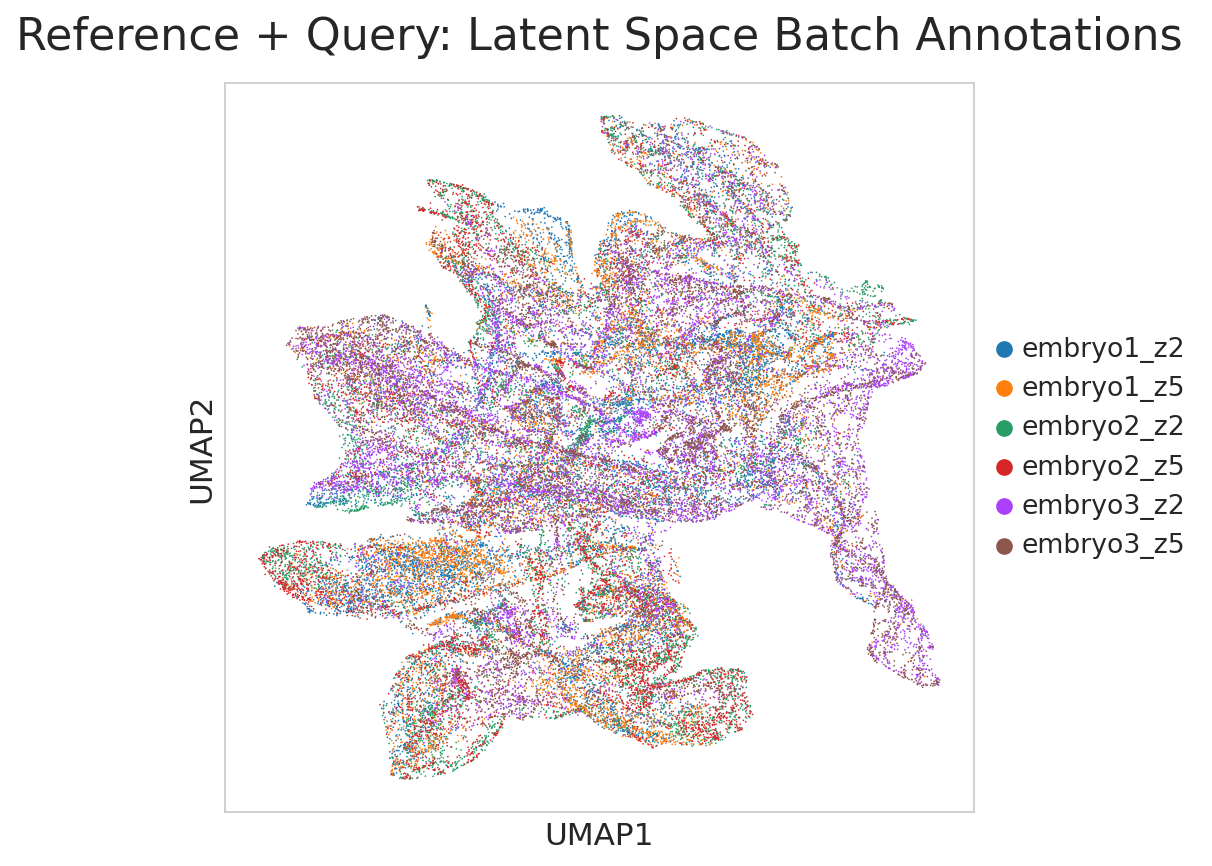

In [104]:
# Plot UMAP with batch annotations
fig = sc.pl.umap(adata_reference_query,
                 color=[condition_key],
                 legend_fontsize=12,
                 return_fig=True)
plt.title("Reference + Query: Latent Space Batch Annotations", size=20, pad=15)
fig.savefig(f"{figure_folder_path}/latent_batches_reference_query.png",
            bbox_inches="tight")

/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:163: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))


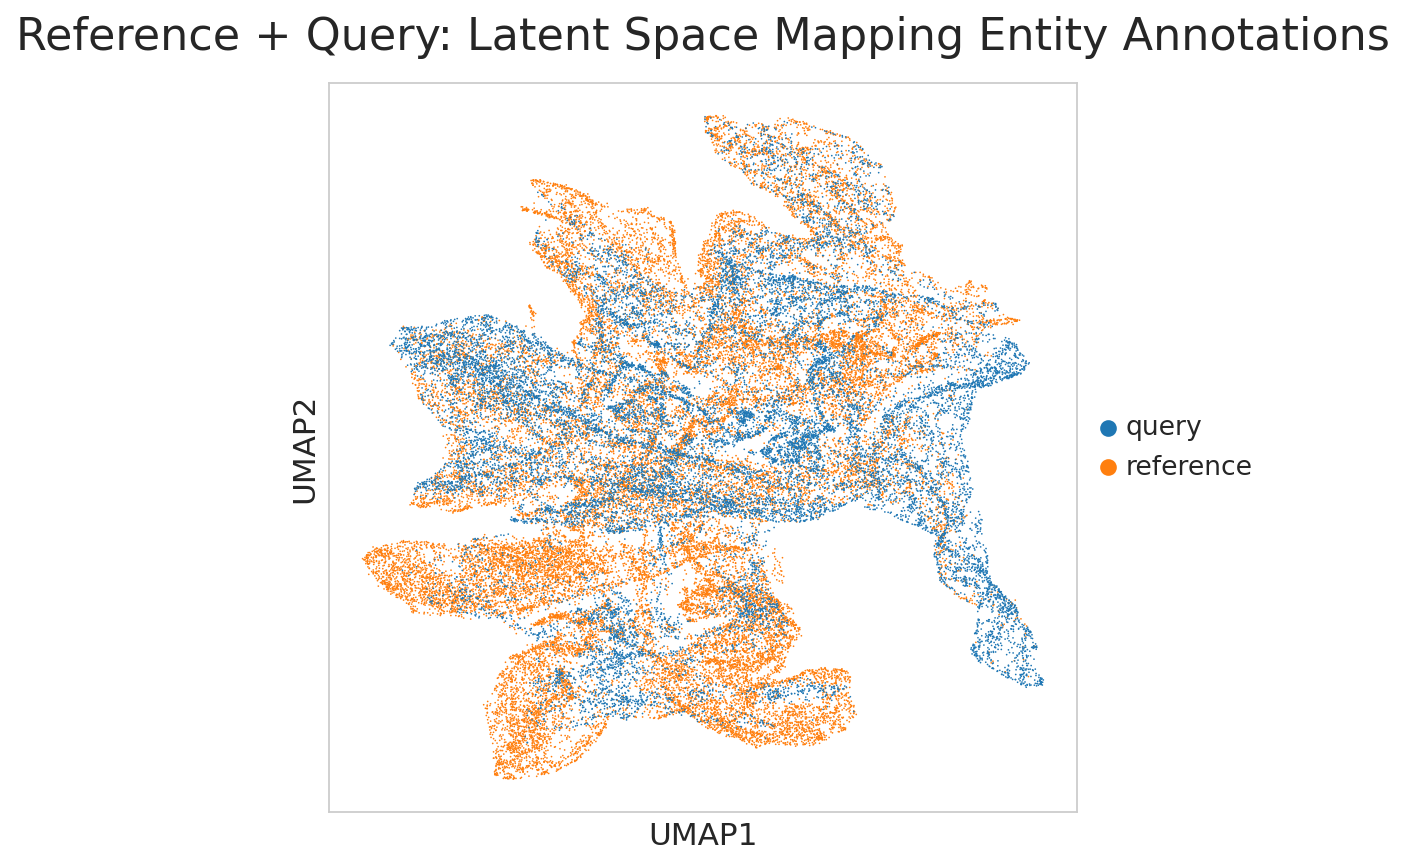

In [105]:
# Plot UMAP with mapping entity annotations
fig = sc.pl.umap(adata_reference_query,
                 color=["mapping_entity"],
                 legend_fontsize=12,
                 return_fig=True)
plt.title("Reference + Query: Latent Space Mapping Entity Annotations", size=20, pad=15)
fig.savefig(f"{figure_folder_path}/latent_mapping_entities_reference_query.png",
            bbox_inches="tight")

/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:163: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))


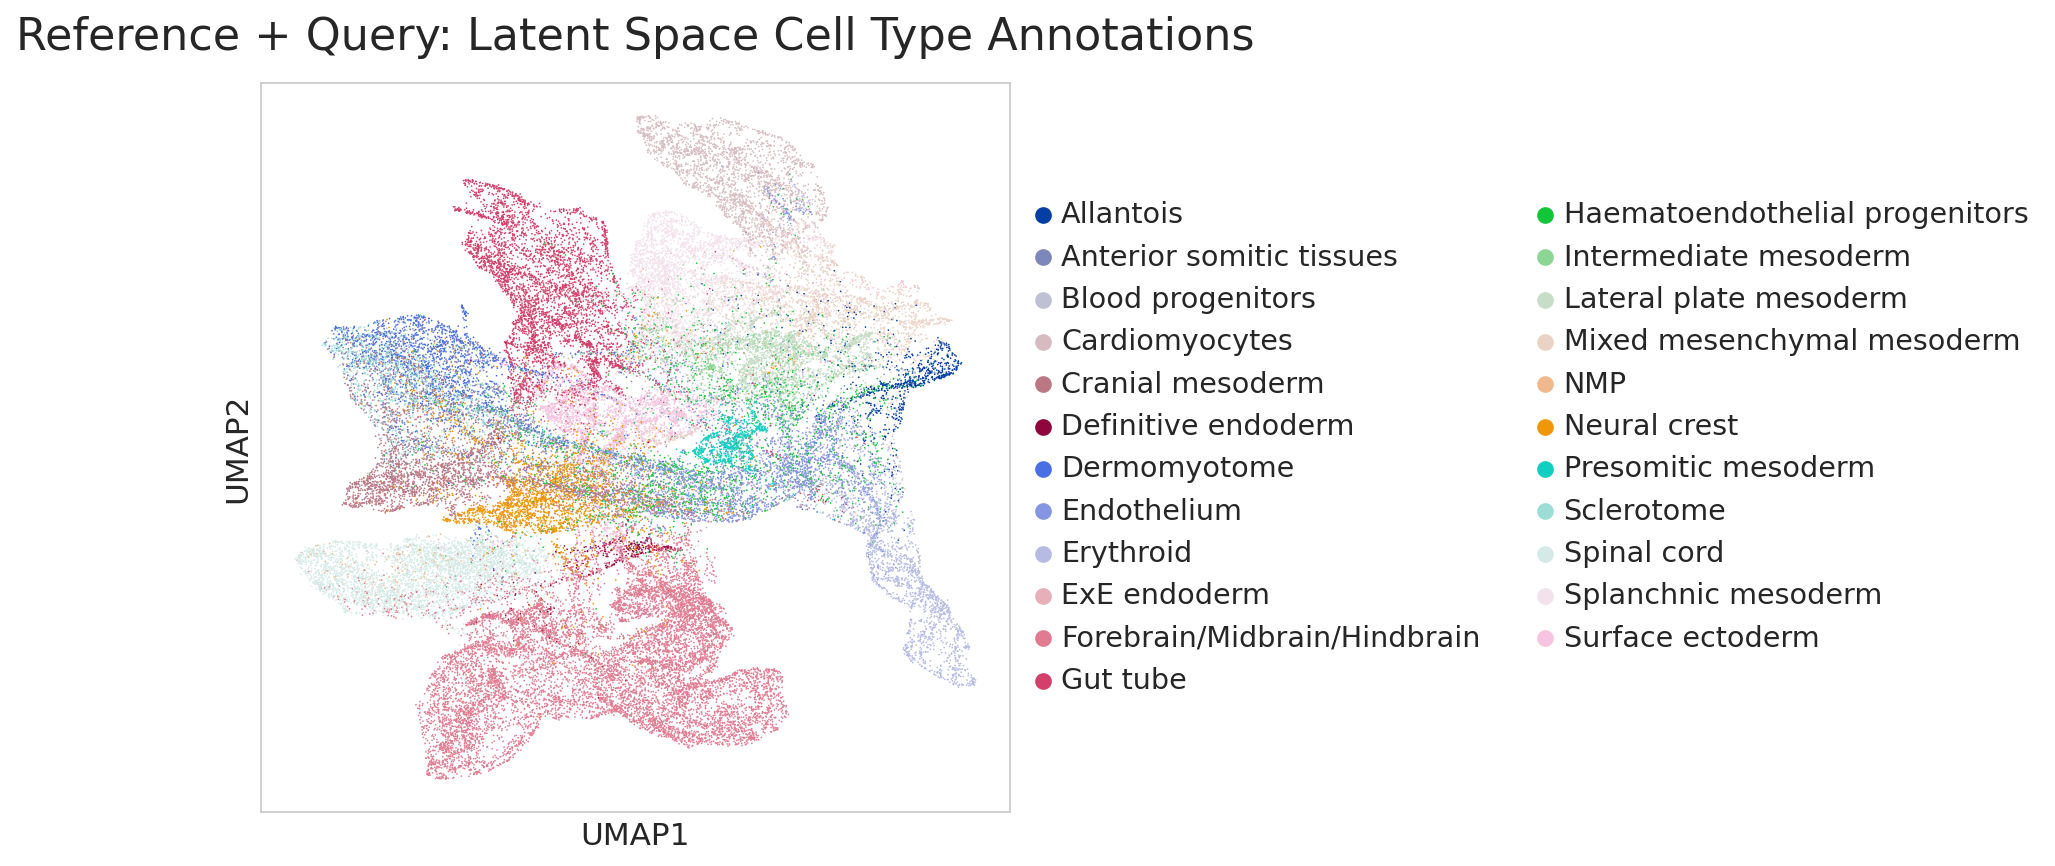

In [106]:
# Plot UMAP with cell type annotations
fig = sc.pl.umap(adata_reference_query,
                 color=[cell_type_key],
                 return_fig=True)
plt.title("Reference + Query: Latent Space Cell Type Annotations", size=20, pad=15)
fig.savefig(f"{figure_folder_path}/latent_cell_types_reference_query.png",
            bbox_inches="tight")

/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:163: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))


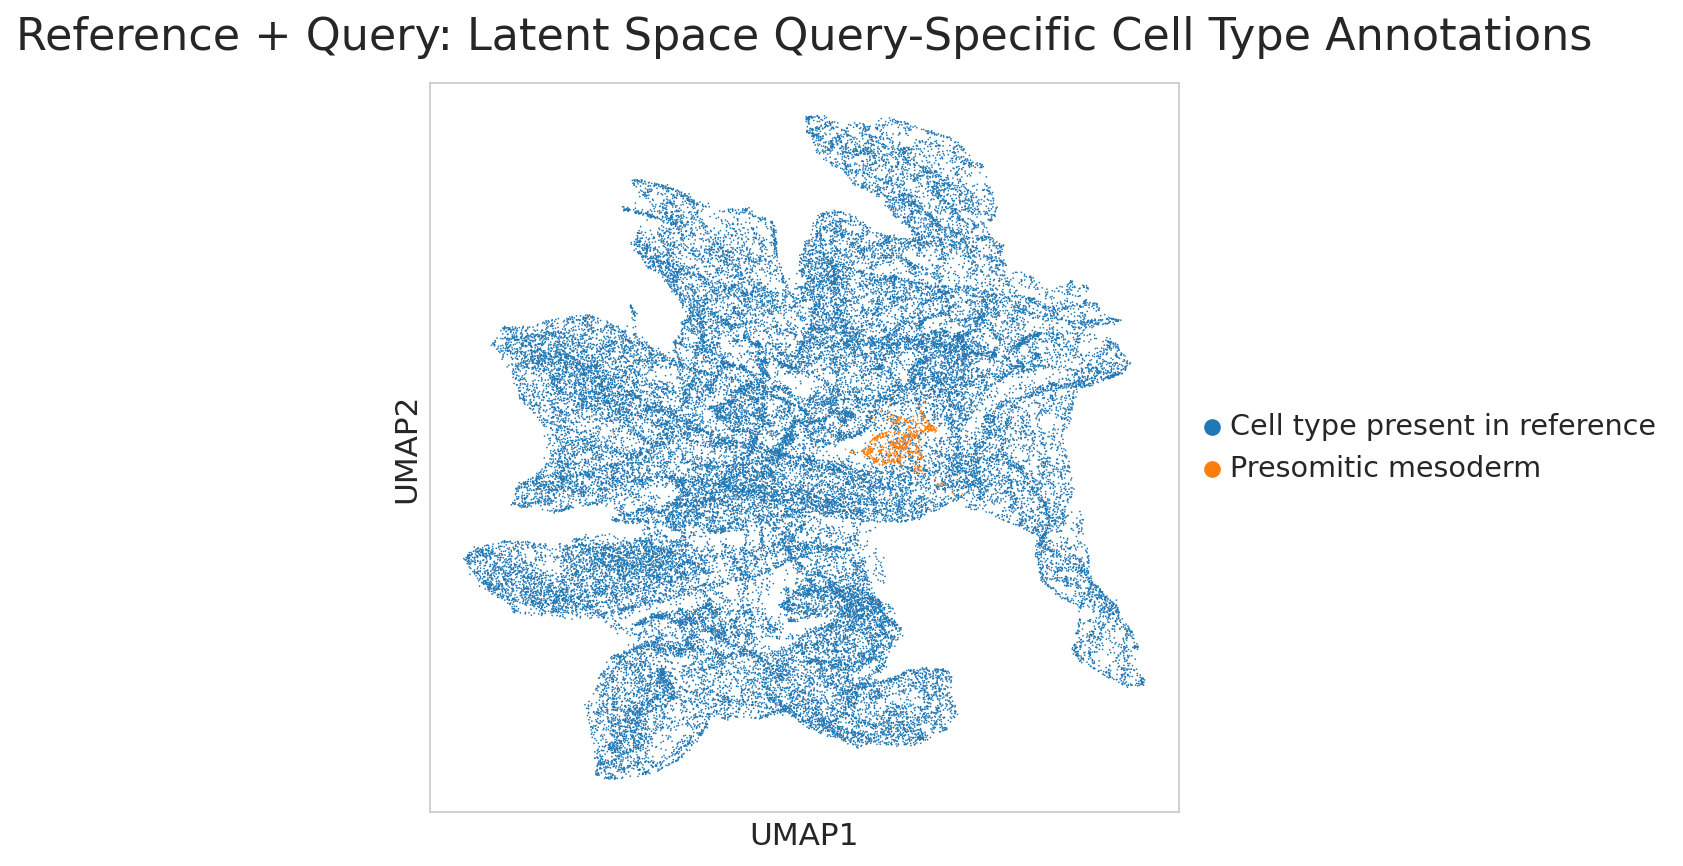

In [107]:
# Plot UMAP with query-specific cell type annotations
fig = sc.pl.umap(adata_reference_query,
                 color=["query_specific_cell_type"],
                 return_fig=True)
plt.title("Reference + Query: Latent Space Query-Specific Cell Type Annotations", size=20, pad=15)
fig.savefig(f"{figure_folder_path}/latent_query_specific_cell_types_reference_query.png",
            bbox_inches="tight")

##### 3.4.2.4 Compute Metrics

In [108]:
# Store computed latent nearest neighbor graph in latent connectivities
adata_reference_query.obsp[f"{latent_knng_key}_connectivities"] = (
    adata_reference_query.obsp["connectivities"])
adata_reference_query.obsp[f"{latent_knng_key}_distances"] = (
    adata_reference_query.obsp["distances"])

# Compute spatial nearest neighbor graph
sc.pp.neighbors(adata_reference_query, use_rep=spatial_key, key_added=spatial_knng_key)

In [109]:
# Compute metrics
metrics_dict_reference_query = {}

# Spatial conservation metrics
metrics_dict_reference_query["cad"] = compute_cad(
    adata=adata_reference_query,
    cell_type_key=cell_type_key,
    spatial_knng_key=spatial_knng_key,
    latent_knng_key=latent_knng_key)
metrics_dict_reference_query["rclisi"] = compute_rclisi(
    adata=adata_reference_query,
    cell_type_key=cell_type_key,
    spatial_knng_key=spatial_knng_key,
    latent_knng_key=latent_knng_key)
    
# Batch correction metrics
metrics_dict_reference_query["batch_asw"] = scib.me.silhouette_batch(
    adata=adata_reference_query,
    batch_key=condition_key,
    label_key=cell_type_key,
    embed="X_umap")
metrics_dict_reference_query["ilisi"] = scib.me.ilisi_graph(
    adata=adata_reference_query,
    batch_key=condition_key,
    type_="knn")
"""
metrics_dict_bbknn["kbet"] = scib.me.kBET(
    adata=model.adata,
    batch_key=condition_key,
    label_key=cell_type_key,
    type_="knn")
"""

print(metrics_dict_reference_query)

# Store metrics to disk
with open(f"{model_artifacts_folder_path}/metrics_reference_query.pickle", "wb") as f:
    pickle.dump(metrics_dict_reference_query, f)

Using precomputed spatial nearest neighbor graph...
Using precomputed latent nearest neighbor graph...
Using precomputed spatial nearest neighbor graph...
Using precomputed latent nearest neighbor graph...
mean silhouette per group:                                 silhouette_score
group                                           
Allantois                               0.838657
Anterior somitic tissues                0.831988
Blood progenitors                       0.717117
Cardiomyocytes                          0.900221
Cranial mesoderm                        0.883395
Definitive endoderm                     0.815887
Dermomyotome                            0.861035
Endothelium                             0.918456
Erythroid                               0.844227
ExE endoderm                            0.625731
Forebrain/Midbrain/Hindbrain            0.924776
Gut tube                                0.830131
Haematoendothelial progenitors          0.896879
Intermediate mesoderm           

##### 3.4.2.5 Visualize Conditional Embedding

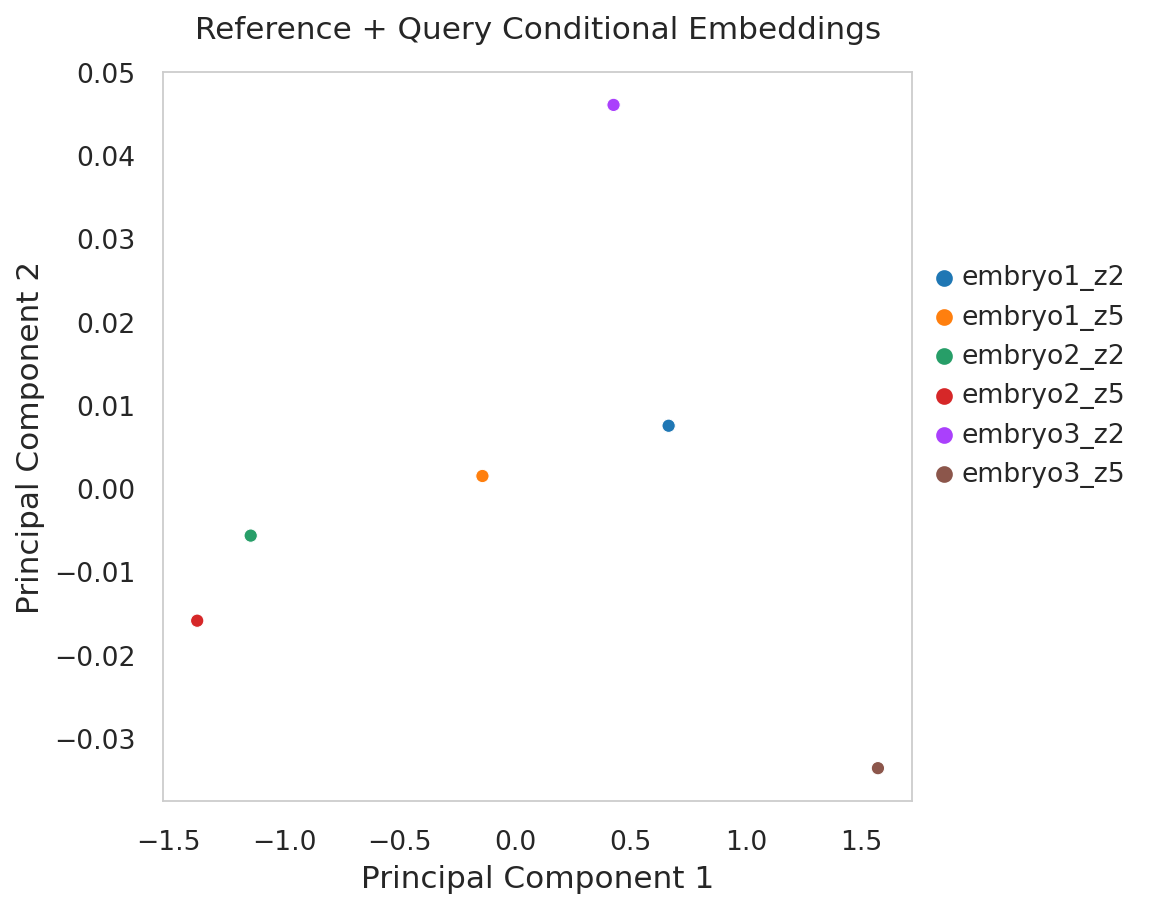

In [110]:
# Get conditional embeddings
cond_embed = model.get_conditional_embeddings()
cond = adata_reference_query.obs["batch"].unique()

# Get top 2 principal components and plot them
pca = KernelPCA(n_components=2, kernel="linear")
cond_embed_pca = pca.fit_transform(cond_embed)
sns.scatterplot(x=cond_embed_pca[:, 0], 
                y=cond_embed_pca[:, 1], 
                hue=cond)
plt.title("Reference + Query Conditional Embeddings", pad=15)
plt.xlabel("Principal Component 1")
plt.xticks(fontsize=12)
plt.ylabel ("Principal Component 2")
plt.yticks(fontsize=12)
plt.legend(bbox_to_anchor=(1.02, 0.75),
           loc=2,
           borderaxespad=0.,
           fontsize=12,
           frameon=False)
plt.savefig(f"{figure_folder_path}/cond_embed_reference_query.png",
            bbox_inches="tight")